# Automatic Speech Recognition

In [1]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pathlib
import random
import warnings
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from hmmlearn.hmm import GMMHMM
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.utils.data as tud
import pandas as pd
import seaborn as sns
import sounddevice as sd
from scipy.io.wavfile import write
import time
from tqdm.auto import tqdm
from dtaidistance import dtw

warnings.filterwarnings('ignore')

c:\Users\zolta\Desktop\MATHOS\AutomaticSpeechRecognition\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.  Get the dataset

In [3]:
# Define the path to the Free Spoken Digit Dataset (FSDD) directory
DATA_DIR = pathlib.Path('fsdd').resolve()

# Check if the FSDD directory already exists
if not DATA_DIR.exists():
    # If it doesn't exist, print a message and clone the dataset from GitHub
    print('Downloading FSDD...')
    !git clone --depth 1 https://github.com/Jakobovski/free-spoken-digit-dataset.git fsdd
else:
    # If it does exist, print a message indicating it has already been downloaded
    print('FSDD already downloaded at', DATA_DIR)

FSDD already downloaded at C:\Users\zolta\Desktop\MATHOS\AutomaticSpeechRecognition\fsdd


In [4]:
# Randomly select one .wav audio file from the 'recordings' folder in the dataset
sample_path = random.choice(glob.glob(str(DATA_DIR / 'recordings' / '*.wav')))

# Print the name of the selected audio file
print('Sample file:', os.path.basename(sample_path))

# Load the audio file using librosa with a sampling rate of 8000 Hz
audio, sr = librosa.load(sample_path, sr=8000)

# Play the audio sample in a Jupyter notebook (or IPython environment)
ipd.Audio(audio, rate=sr)

Sample file: 8_theo_18.wav


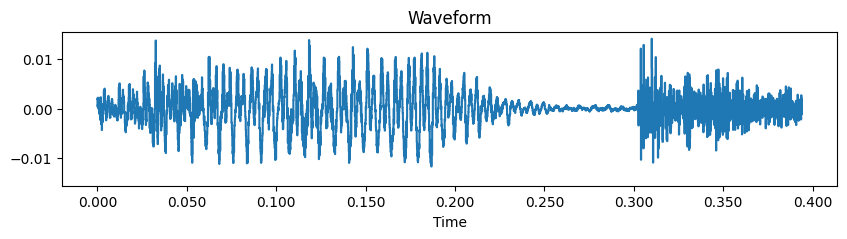

In [5]:
# Display waveform 
plt.figure(figsize=(10,2))  # Set the figure size for the waveform plot
librosa.display.waveshow(audio, sr=sr)  # Plot the audio waveform
plt.title('Waveform')  # Set the title of the plot
plt.show()  # Display the plot

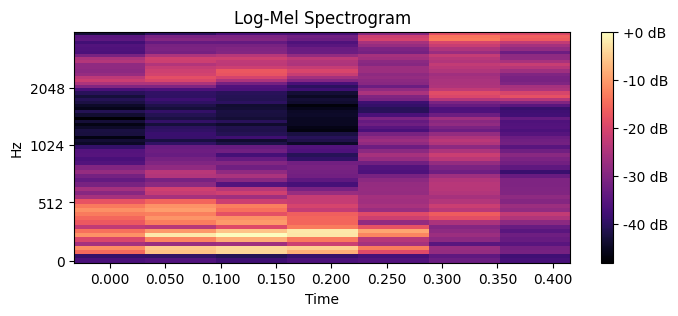

In [6]:
# Display the Log-Mel spectrogram
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=64, fmax=4000)  # Compute the Mel spectrogram with 64 Mel bands and max freq of 4000 Hz
log_S = librosa.power_to_db(S, ref=np.max)  # Convert the power spectrogram to decibel (dB) units
plt.figure(figsize=(8,3))  # Set the figure size for the spectrogram plot
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')  # Display the spectrogram with time and Mel frequency axes
plt.colorbar(format='%+2.0f dB')  # Add a color bar to indicate dB scale
plt.title('Log-Mel Spectrogram')  # Set the title of the plot
plt.show()  # Display the plot

## 2.  Feature extraction

In [7]:
# Function to extract MFCC and delta MFCC features from an audio file
def extract_mfcc(path, sr=8000, n_mfcc=13):
    y, _ = librosa.load(path, sr=sr)  # Load the audio file with a given sample rate
    mfcc_feat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=256, n_fft=512)  # Extract MFCC features

    if mfcc_feat.shape[1] < 5:
        # If there are too few frames, skip delta computation and use zeros
        delta_feat = np.zeros_like(mfcc_feat)
    else:
        # Compute delta (time derivative) features
        delta_feat = librosa.feature.delta(mfcc_feat, width=5)

    return np.vstack([mfcc_feat, delta_feat]).T  # Stack MFCC and delta features vertically and transpose (shape: [T, 26])

# Function to extract Log-Mel spectrogram features from an audio file
def extract_logmel(path, sr=8000, n_mels=64, max_frames=128):
    y, _ = librosa.load(path, sr=sr)  # Load the audio file
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=4000)  # Compute the Mel spectrogram
    logmel = librosa.power_to_db(mel, ref=np.max)  # Convert to log scale (decibels)

    # Pad or truncate the spectrogram to a fixed number of frames (for CNN input)
    if logmel.shape[1] < max_frames:
        # Pad with the minimum log-mel value if too short
        pad = np.full((n_mels, max_frames - logmel.shape[1]), logmel.min())
        logmel = np.hstack([logmel, pad])
    else:
        # Truncate if too long
        logmel = logmel[:, :max_frames]

    return logmel  # Return log-mel spectrogram (shape: [64, max_frames])


In [8]:
# Build feature lists for all recordings

# Get a sorted list of all .wav files in the 'recordings' directory
file_list = sorted(pathlib.Path(DATA_DIR / 'recordings').glob('*.wav'))

# Extract the digit label from each filename (e.g., '3_jackson_1.wav' → 3)
labels = [int(f.name.split('_')[0]) for f in file_list]

# Extract MFCC + delta features for each audio file
mfcc_sequences = [extract_mfcc(str(p)) for p in file_list]

# Extract log-mel spectrograms for each audio file
logmel_images = [extract_logmel(str(p)) for p in file_list]

# Print the total number of samples processed
print('Total samples:', len(file_list))

Total samples: 3000


In [9]:
# Create a list of indices corresponding to all samples
idx = list(range(len(file_list)))

# Split indices into training and testing sets with 80/20 ratio
# Use stratification to maintain class distribution across splits
train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=42, stratify=labels
)

# Print the number of samples in each split
print(f'Train: {len(train_idx)}, Test: {len(test_idx)}')

Train: 2400, Test: 600


## 3.  DTW 1‑NN baseline

DTW Matching:   0%|          | 0/600 [00:00<?, ?it/s]

DTW Matching: 100%|██████████| 600/600 [14:04<00:00,  1.41s/it]

DTW accuracy: 0.5966666666666667


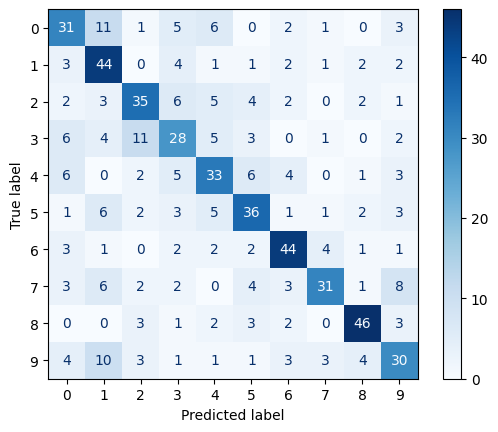

In [10]:
# Function to compute DTW (Dynamic Time Warping) distance between two MFCC sequences
def dtw_distance(a, b):
    return dtw.distance(a[:, 0], b[:, 0])  # Compare only the first MFCC coefficient (typically energy)

# Predict the label of a sample by finding the nearest training sequence using DTW
def predict_dtw(sample_seq, ref_idx):
    # Compute DTW distances between the sample and each reference sequence
    distances = [dtw_distance(sample_seq, mfcc_sequences[r]) for r in ref_idx]
    # Get the index of the reference sequence with the minimum distance
    best = ref_idx[int(np.argmin(distances))]
    return labels[best]  # Return the label of the best match

# True labels for the test set
y_true = [labels[i] for i in test_idx]

# Predicted labels using DTW nearest neighbor search
y_pred = [predict_dtw(mfcc_sequences[i], train_idx) for i in tqdm(test_idx, desc="DTW Matching")]

# Compute and print DTW classification accuracy
dtw_acc = accuracy_score(y_true, y_pred)
print('DTW accuracy:', dtw_acc)

# Compute and display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')  # Use blue color map for visualization

## 4.  GMM‑HMM per digit

Training HMMs: 100%|██████████| 10/10 [06:13<00:00, 37.30s/it]


HMM accuracy: 0.9916666666666667


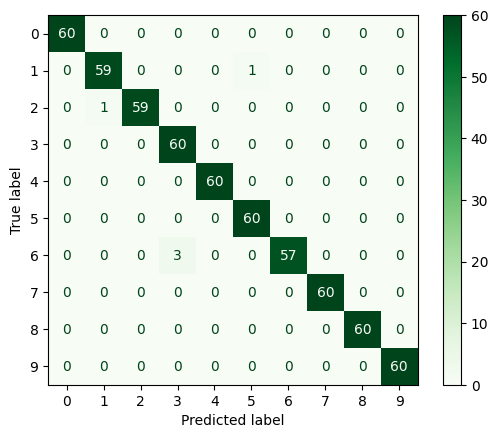

In [11]:
# Train a separate GMM-HMM model for each digit (0–9)
digit_models = {}
for d in tqdm(range(10), desc="Training HMMs"):
    # Select MFCC sequences corresponding to digit d from the training set
    seqs = [mfcc_sequences[i] for i in train_idx if labels[i] == d]
    lengths = [len(s) for s in seqs]  # Lengths of each sequence (required for HMM training)
    X = np.vstack(seqs)  # Stack all sequences into one big array for training

    # Create and train a GMM-HMM model
    model = GMMHMM(
        n_components=5,       # Number of HMM states
        n_mix=4,              # Number of Gaussian mixtures per state
        covariance_type='diag',  # Diagonal covariance matrices
        n_iter=100,           # Number of training iterations
        verbose=False         # No verbose output
    )
    model.fit(X, lengths)  # Train the model on the stacked data with sequence lengths
    digit_models[d] = model  # Store the trained model for digit d

# Predict the digit label by scoring the sequence with each trained HMM and choosing the best
def predict_hmm(seq):
    scores = {d: m.score(seq) for d, m in digit_models.items()}  # Score each model on the input sequence
    return max(scores, key=scores.get)  # Return the digit with the highest score

# Predict labels for the test set using the trained HMMs
y_pred_hmm = [predict_hmm(mfcc_sequences[i]) for i in test_idx]

# Compute and print HMM classification accuracy
hmm_acc = accuracy_score(y_true, y_pred_hmm)
print('HMM accuracy:', hmm_acc)

# Compute and display the confusion matrix for HMM predictions
cm = confusion_matrix(y_true, y_pred_hmm)
ConfusionMatrixDisplay(cm).plot(cmap='Greens')  # Use green color map for visualization


## 5.  CNN classifier

In [12]:
# CNN model for digit classification
class CNNDigit(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


Training: 100%|██████████| 300/300 [05:41<00:00,  1.14s/it]

CNN accuracy (best model): 0.9183333333333333


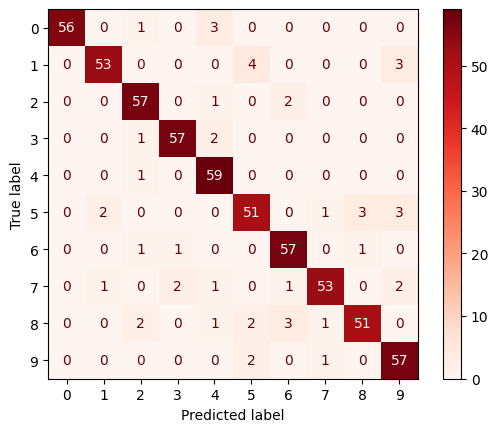

In [14]:
# Build tensors from log-mel images and labels
X_images = torch.tensor(np.stack([img for img in logmel_images]), dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(labels, dtype=torch.long)

# Normalize the input data
X_images = (X_images - X_images.mean()) / X_images.std()

# Create TensorDatasets and DataLoaders for training and testing
train_ds = tud.TensorDataset(X_images[train_idx], y_tensor[train_idx])
test_ds  = tud.TensorDataset(X_images[test_idx],  y_tensor[test_idx])
train_loader = tud.DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = tud.DataLoader(test_ds,  batch_size=32)

# Initialize model, optimizer, scheduler, and loss function
model = CNNDigit().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

# Train the model and save the best version (based on loss)
best_loss = float('inf')
best_model_state = None

EPOCHS = 300
for epoch in tqdm(range(EPOCHS), desc='Training'):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()
    
    scheduler.step()

# Load the best model weights into a new instance
best_model = CNNDigit().to(device)
best_model.load_state_dict(best_model_state)
best_model.eval()

# Evaluate the model on the test set
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = best_model(xb).argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_true.extend(yb.numpy())

# Compute and display accuracy and confusion matrix
cnn_acc = accuracy_score(all_true, all_preds)
print('CNN accuracy (best model):', cnn_acc)

cm = confusion_matrix(all_true, all_preds)
ConfusionMatrixDisplay(cm).plot(cmap='Reds')

## 6.  Accuracy comparison

DTW    0.596667
HMM    0.991667
CNN    0.918333
dtype: float64


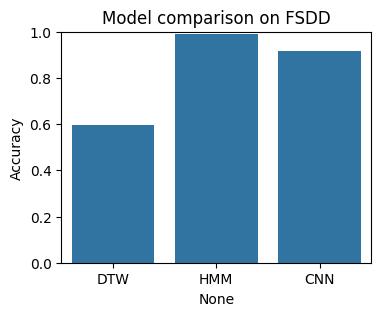

In [15]:
# Create a Series to store accuracy scores of different models
acc = pd.Series({'DTW': dtw_acc, 'HMM': hmm_acc, 'CNN': cnn_acc})
print(acc)

# Plot a bar chart comparing model accuracies
plt.figure(figsize=(4,3))
sns.barplot(x=acc.index, y=acc.values)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model comparison on FSDD')
plt.show()

## 7.  Record your own digit

In [16]:
fs = 8000  # Sampling rate
seconds = 1  # Duration of the recording

print('>> Speak a single digit (0-9) after the beep...')
time.sleep(0.5)

# Play a short beep sound before recording
sd.play(0.5 * np.sin(2 * np.pi * 440 * np.linspace(0, 0.2, int(0.2 * fs))), fs)
sd.wait()

# Record audio for the specified duration
recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()

# Save the recording to a WAV file
custom_digit_file_name = 'my_digit.wav'
write(custom_digit_file_name, fs, recording)

print('Saved to', custom_digit_file_name)

# Play back the recorded audio
ipd.Audio(custom_digit_file_name)

>> Speak a single digit (0-9) after the beep...
Saved to my_digit.wav


### Predict using each model

In [17]:
# Extract features from the custom recorded digit
seq = extract_mfcc(custom_digit_file_name)  # MFCC sequence for DTW and HMM
img = extract_logmel(custom_digit_file_name)  # Log-mel spectrogram for CNN

# Prepare input tensor for CNN: shape (1, 1, 64, T)
img_t = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Predict digit using all three models
print('DTW→', predict_dtw(seq, train_idx))
print('HMM→', predict_hmm(seq))
with torch.no_grad():
    p = model(img_t.to(device)).argmax(1).item()
print('CNN→', p)

DTW→ 6
HMM→ 7
CNN→ 1
